# Evaluation of the health of forests in Bhutan
#### Analysis with satellite images of Sentinel -2
#### Presentation of the NDVI Index for a quick assessment of the health of forests in Bhutan.

In [1]:
# Import necessary packages
import os
import json
import up42
import folium
import pyproj 
import matplotlib
import numpy as np
import pandas as pd  
import rasterio as rio
import geopandas as gpd   
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from rasterio import plot
from folium import plugins
from functools import partial
from rasterio import features  
from matplotlib import pyplot, colors
from rasterio.plot import reshape_as_raster, show                                                               
from shapely.geometry import shape as shapely_shp                             
from shapely.ops import cascaded_union, transform     
from rasterio.warp import calculate_default_transform, reproject, Resampling  
from shapely.geometry import LineString, MultiPolygon, Point, Polygon, box    

In [2]:
# Allows for ignoring errors + division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Set directory to download the results
quicklook_dir = "./results/catalog/sentinel2/"
sentinel_dir = "./results/sentinel_2/"

In [4]:
# Authentification
# https://console.up42.com/ --> Developers
up42.authenticate(project_id="a7c22b41-77e4-4858-a90f-d22caa7788c2", 
                  project_api_key="XFhdgIzI.PqLIPJQXqucVbEf3wtNGlZ8lw2DiH7aBZWF")

2021-07-01 13:37:21,056 - Authentication with UP42 successful!


In [5]:
# Checking the blocks
#up42.get_blocks()
#up42.get_block_details()

In [6]:
# Get the current working directory
os.getcwd()

'/home/diego/GITHUP_REPO/Challenge_up42'

### Catalog Search
#### Search cloudfree Sentinel-2 images for the AOI and visualise the quicklooks.

In [7]:
# Geojason of the Bhutan forest
# obtained from https://mapcruzin.com/bhutan-shapefiles/bhutan_natural.zip
Bhutan_forest = json.load(open('bhutan_forest.geojson'))

# Area of interest inside of the Bhutan forest
aoi = up42.read_vector_file('AOI_Bhutan_Forest.geojson', as_dataframe=False)

2021-07-01 13:37:21,270 - Searching catalog with search_parameters: {'datetime': '2021-01-01T00:00:00Z/2021-05-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((90.23863465716029, 27.105424599204458), (90.64090865457698, 27.105424599204458), (90.64090865457698, 27.43797110373558), (90.23863465716029, 27.43797110373558), (90.23863465716029, 27.105424599204458)),)}, 'limit': 10, 'query': {'dataBlock': {'in': ['sobloo-s2-l1c-fullscene', 'sobloo-s2-l1c-aoiclipped']}, 'cloudCoverage': {'lte': 10}}, 'sortby': [{'field': 'properties.cloudCoverage', 'direction': 'asc'}]}
2021-07-01 13:37:22,992 - 3 results returned.


,geometry,id,acquisitionDate,constellation,collection,providerName,blockNames,cloudCoverage,up42:usageType,providerProperties,sceneId,resolution,deliveryTime,producer
0,"POLYGON ((89.97685 27.00171, 90.62726 27.01312...",2401b797-8b0a-4749-99a7-0ab9d1dcec1c,2021-01-04T04:42:01Z,Sentinel-2,Sentinel-2,sobloo-image,"[sobloo-s2-l1c-fullscene, sobloo-s2-l1c-aoicli...",0.8556,[ANALYTICS],"{'timeStamp': 1609735321024, 'uid': '2401b797-...",S2A_MSIL1C_20210104T044201_N0209_R033_T46RBR_2...,10.0,MINUTES,ESA
1,"POLYGON ((90.11468 27.00413, 91.08261 27.02111...",6e393858-6124-435e-b436-33b1a634cd96,2021-01-06T04:31:49Z,Sentinel-2,Sentinel-2,sobloo-image,"[sobloo-s2-l1c-fullscene, sobloo-s2-l1c-aoicli...",7.9124,[ANALYTICS],"{'timeStamp': 1609907509024, 'uid': '6e393858-...",S2B_MSIL1C_20210106T043149_N0209_R133_T46RBR_2...,10.0,MINUTES,ESA
2,"POLYGON ((89.97685 27.00171, 90.64407 27.01342...",2451adcf-dbdf-42b9-bda0-eb00cc3a0ebe,2021-04-24T04:37:01Z,Sentinel-2,Sentinel-2,sobloo-image,"[sobloo-s2-l1c-fullscene, sobloo-s2-l1c-aoicli...",8.1775,[ANALYTICS],"{'timeStamp': 1619239021024, 'uid': '2451adcf-...",S2A_MSIL1C_20210424T043701_N0300_R033_T46RBR_2...,10.0,MINUTES,ESA


2021-07-01 13:37:23,118 - Getting quicklooks from provider sobloo-image for image_ids: ['2401b797-8b0a-4749-99a7-0ab9d1dcec1c', '6e393858-6124-435e-b436-33b1a634cd96', '2451adcf-dbdf-42b9-bda0-eb00cc3a0ebe']
2021-07-01 13:37:23,119 - Download directory: results/catalog/sentinel2
100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


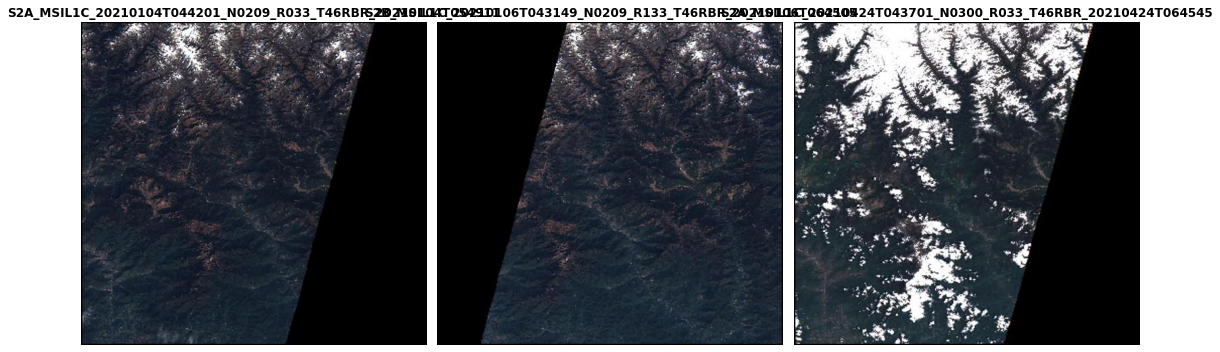

In [8]:
# Search the area via catalog search
# Warning!! This function is deprecated

catalog = up42.initialize_catalog()

search_parameters = catalog.construct_parameters(geometry=aoi, 
                                                 start_date="2021-01-01",
                                                 end_date="2021-05-31",
                                                 sensors=["sentinel2"],
                                                 max_cloudcover=10,
                                                 sortby='cloudCoverage')

search_results = catalog.search(search_parameters=search_parameters)
display(search_results.head())

catalog.download_quicklooks(image_ids=search_results.id.to_list(), 
                            sensor="sentinel2", 
                            output_directory=quicklook_dir)

catalog.plot_quicklooks(figsize=(15,5), titles=search_results.sceneId.to_list())

# Select least cloud scene for further workflow
aoi["sceneId"] = search_results.sceneId.to_list()[0]

### NDVI project using Sentinel-2 for a Bhutan forest sample
#### Find the most current image available as a sample

In [9]:
# Initialize the project
# https://console.up42.com/ --> Projects
project = up42.initialize_project()
    
# Init workflow --> forests_bhutan
workflow = project.create_workflow(name="forests_bhutan_sentinel_2", use_existing=True)

2021-07-01 13:37:27,235 - Initialized Project(name: Up42_challenge, project_id: a7c22b41-77e4-4858-a90f-d22caa7788c2, description: Evaluate the health of forests in Bhutan - Bruno Brazil Associates, createdAt: 2021-06-29T13:45:22.401521Z)
2021-07-01 13:37:27,236 - Getting existing workflows in project ...
2021-07-01 13:37:28,410 - Got 3 workflows for project a7c22b41-77e4-4858-a90f-d22caa7788c2.
100%|██████████| 3/3 [00:01<00:00,  2.13it/s]
2021-07-01 13:37:29,826 - Using existing workflow: forests_bhutan_sentinel_2 - 5196073f-5aea-43d6-9d91-d55cbf124172


In [10]:
# Workflow with our desired data block
input_tasks = ["Sentinel-2 L2A Analytic (GeoTIFF)"]

# Update workflow object with our desired data block as input_task(s)
workflow.add_workflow_tasks(input_tasks)
workflow

2021-07-01 13:37:33,855 - Added tasks to workflow: [{'name': 'esa-s2-l2a-gtiff-analytic:1', 'parentName': None, 'blockId': 'e13d8e92-2763-4640-80d6-1501b2729707'}]


Workflow(name: forests_bhutan_sentinel_2, workflow_id: 5196073f-5aea-43d6-9d91-d55cbf124172, description: , createdAt: 2021-06-30T13:17:22.499736Z, project_id: a7c22b41-77e4-4858-a90f-d22caa7788c2, workflow_tasks: {'esa-s2-l2a-gtiff-analytic:1': '1.3.1'}

In [11]:
# Construct input parameters
input_parameters = workflow.construct_parameters(geometry=aoi, 
                                                 geometry_operation='contains', 
                                                 start_date="2021-01-01",
                                                 end_date="2021-06-29",
                                                 limit=10)

# Update input parameters
input_parameters["esa-s2-l2a-gtiff-analytic:1"].update({"max_cloud_cover":10})
input_parameters

{'esa-s2-l2a-gtiff-analytic:1': {'time': '2021-01-01T00:00:00Z/2021-06-29T23:59:59Z',
  'limit': 10,
  'max_cloud_cover': 10,
  'contains': {'type': 'Polygon',
   'coordinates': (((90.23863465716029, 27.105424599204458),
     (90.64090865457698, 27.105424599204458),
     (90.64090865457698, 27.43797110373558),
     (90.23863465716029, 27.43797110373558),
     (90.23863465716029, 27.105424599204458)),)}}}

In [12]:
# Price estimation
workflow.estimate_job(input_parameters)

2021-07-01 13:37:43,787 - Estimated: 1-1 Credits, Duration: 0-0 min.


{'esa-s2-l2a-gtiff-analytic:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0,
    'max': 0},
   'credit': {'min': 0, 'max': 0}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}}}

In [13]:
# Run test job to query data availability and check the configuration.
test_job = workflow.test_job(input_parameters, track_status=True)

2021-07-01 13:37:43,798 - +++++++++++++++++++++++++++++++++
2021-07-01 13:37:43,801 - Running this job as Test Query...
2021-07-01 13:37:43,801 - +++++++++++++++++++++++++++++++++
2021-07-01 13:37:43,802 - Selected input_parameters: {'esa-s2-l2a-gtiff-analytic:1': {'time': '2021-01-01T00:00:00Z/2021-06-29T23:59:59Z', 'limit': 10, 'max_cloud_cover': 10, 'contains': {'type': 'Polygon', 'coordinates': (((90.23863465716029, 27.105424599204458), (90.64090865457698, 27.105424599204458), (90.64090865457698, 27.43797110373558), (90.23863465716029, 27.43797110373558), (90.23863465716029, 27.105424599204458)),)}}, 'config': {'mode': 'DRY_RUN'}}
2021-07-01 13:37:45,348 - Created and running new job: bd5bf088-19c0-4287-b460-f4e89d7513e1.
2021-07-01 13:37:45,825 - Tracking job status continuously, reporting every 30 seconds...
2021-07-01 13:37:58,717 - Job finished successfully! - bd5bf088-19c0-4287-b460-f4e89d7513e1


In [14]:
# Run the actual job
job = workflow.run_job(input_parameters=input_parameters, track_status=True)

2021-07-01 13:38:03,732 - Selected input_parameters: {'esa-s2-l2a-gtiff-analytic:1': {'time': '2021-01-01T00:00:00Z/2021-06-29T23:59:59Z', 'limit': 10, 'max_cloud_cover': 10, 'contains': {'type': 'Polygon', 'coordinates': (((90.23863465716029, 27.105424599204458), (90.64090865457698, 27.105424599204458), (90.64090865457698, 27.43797110373558), (90.23863465716029, 27.43797110373558), (90.23863465716029, 27.105424599204458)),)}}}
2021-07-01 13:38:08,857 - Created and running new job: 487de3e6-2160-4b6a-a2d5-9ff420d42118.
2021-07-01 13:38:09,564 - Tracking job status continuously, reporting every 30 seconds...
2021-07-01 13:38:45,514 - Job is RUNNING! - 487de3e6-2160-4b6a-a2d5-9ff420d42118
2021-07-01 13:39:18,981 - Job is RUNNING! - 487de3e6-2160-4b6a-a2d5-9ff420d42118
2021-07-01 13:39:52,989 - Job is RUNNING! - 487de3e6-2160-4b6a-a2d5-9ff420d42118
2021-07-01 13:40:27,220 - Job is RUNNING! - 487de3e6-2160-4b6a-a2d5-9ff420d42118
2021-07-01 13:41:01,938 - Job is RUNNING! - 487de3e6-2160-4b6

In [15]:
# Download results and quicklooks to "results/sentinel/"" folder in current directory
job.download_results(sentinel_dir)
job.download_quicklooks(sentinel_dir)

2021-07-01 13:54:57,389 - Downloading results of job 487de3e6-2160-4b6a-a2d5-9ff420d42118
2021-07-01 13:54:57,391 - Download directory: results/sentinel_2
913168it [00:01, 464137.87it/s]
2021-07-01 13:59:48,302 - Download successful of 105 files to output_directory 'results/sentinel_2': ['S2B_46RBR_20210516_1_L2A_B06.tif', 'S2B_46RBR_20210516_1_L2A_vrt.vrt', 'S2B_46RBR_20210516_1_L2A_B12.tif', 'S2B_46RBR_20210516_1_L2A_B04.tif', 'S2B_46RBR_20210516_1_L2A_B09.tif', 'S2B_46RBR_20210516_1_L2A_B07.tif', 'S2B_46RBR_20210516_1_L2A_B02.tif', 'S2B_46RBR_20210516_1_L2A_B8A.tif', 'S2B_46RBR_20210516_1_L2A_B11.tif', 'S2B_46RBR_20210516_1_L2A_B05.tif', 'S2B_46RBR_20210516_1_L2A_B01.tif', 'S2B_46RBR_20210516_1_L2A_B08.tif', 'S2B_46RBR_20210516_1_L2A_B03.tif', 'S2B_46RBR_20210625_0_L2A_B02.tif', 'S2B_46RBR_20210625_0_L2A_B03.tif', 'S2B_46RBR_20210625_0_L2A_B08.tif', 'S2B_46RBR_20210625_0_L2A_B04.tif', 'S2B_46RBR_20210625_0_L2A_B06.tif', 'S2B_46RBR_20210625_0_L2A_B12.tif', 'S2B_46RBR_20210625_0_L2A_B

['results/sentinel_2/quicklook_S2A_46RBR_20210104_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2A_46RBR_20210424_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2A_46RBR_20210504_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2A_46RBR_20210514_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210106_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210516_1_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210519_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210625_0_L2A.jpg']

In [16]:
# Print the Job Results
job.results

['results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B06.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_vrt.vrt',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B12.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B04.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B09.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B07.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B02.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B8A.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B11.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B05.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B01.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B08.tif',
 'results/sentinel_2/S2B_46R

In [17]:
# Similarly store path for quicklook
ql_path = job.quicklooks[4]
ql_path

'results/sentinel_2/quicklook_S2B_46RBR_20210106_0_L2A.jpg'

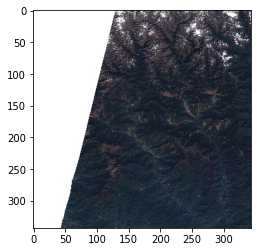

In [18]:
# Plot of quicklook: the latest and cloudless image
img = mpimg.imread(ql_path)
imgplot = plt.imshow(img)
plt.show()

In [19]:
# From the quick look after the download, we select the latest and cloudless image
# which is: S2B_46RBR_20210106_0_L2A
data_to_use='./results/sentinel_2/S2B_46RBR_20210106_0_L2A/'

In [20]:
# Store results and quicklook paths to separate variables
raster_path = [i for i in os.listdir(data_to_use) if i.endswith('.tif')]
metadata_path = [i for i in job.results if i.endswith('.json')][0]

In [21]:
# Sort the Band to make the selection easier
raster_path.sort()
raster_path

['S2B_46RBR_20210106_0_L2A_B01.tif',
 'S2B_46RBR_20210106_0_L2A_B02.tif',
 'S2B_46RBR_20210106_0_L2A_B03.tif',
 'S2B_46RBR_20210106_0_L2A_B04.tif',
 'S2B_46RBR_20210106_0_L2A_B05.tif',
 'S2B_46RBR_20210106_0_L2A_B06.tif',
 'S2B_46RBR_20210106_0_L2A_B07.tif',
 'S2B_46RBR_20210106_0_L2A_B08.tif',
 'S2B_46RBR_20210106_0_L2A_B09.tif',
 'S2B_46RBR_20210106_0_L2A_B11.tif',
 'S2B_46RBR_20210106_0_L2A_B12.tif',
 'S2B_46RBR_20210106_0_L2A_B8A.tif']

In [22]:
# Complete path of images Red and Nir
path4 = data_to_use + raster_path[3]
path8 = data_to_use + raster_path[7]
path4, path8

('./results/sentinel_2/S2B_46RBR_20210106_0_L2A/S2B_46RBR_20210106_0_L2A_B04.tif',
 './results/sentinel_2/S2B_46RBR_20210106_0_L2A/S2B_46RBR_20210106_0_L2A_B08.tif')

In [23]:
# Import bands as separate raster
band4 = rio.open(path4) #red
band8 = rio.open(path8) #nir

In [24]:
# Number of raster rows, columns
band4.height, band4.width

# Type of raster byte
band4.dtypes[0]

# Raster sytem of reference
band4.crs

# Raster transform parameters
band4.transform

# Raster values as matrix array
band4.read(1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [25]:
# Generate nir and red objects as arrays in float64 format
red = band4.read(1).astype('float64')
nir = band8.read(1).astype('float64')

# NDVI calculation, empty cells or nodata cells are reported as 0
ndvi=np.where(
    (nir+red)==0., 
    0, 
    (nir-red)/(nir+red))
ndvi[:5,:5]

# Export ndvi image
ndviImage = rio.open('./results/sentinel_2/ndvi_Image.tiff','w',driver='Gtiff',
                     width=band4.width, 
                     height = band4.height, 
                     count=1, crs=band4.crs, 
                     transform=band4.transform, 
                     dtype='float64')

ndviImage.write(ndvi,1)
ndviImage.close()

### Applying a color scheme to visualize the NDVI values on the new image
#### The values in our NDVI will range from -1 to 1. To best visualize this, we want to use a diverging color scheme, and we want to center the colorbar at a defined midpoint.

In [26]:
class MidpointNormalize(colors.Normalize):
   
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
       
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

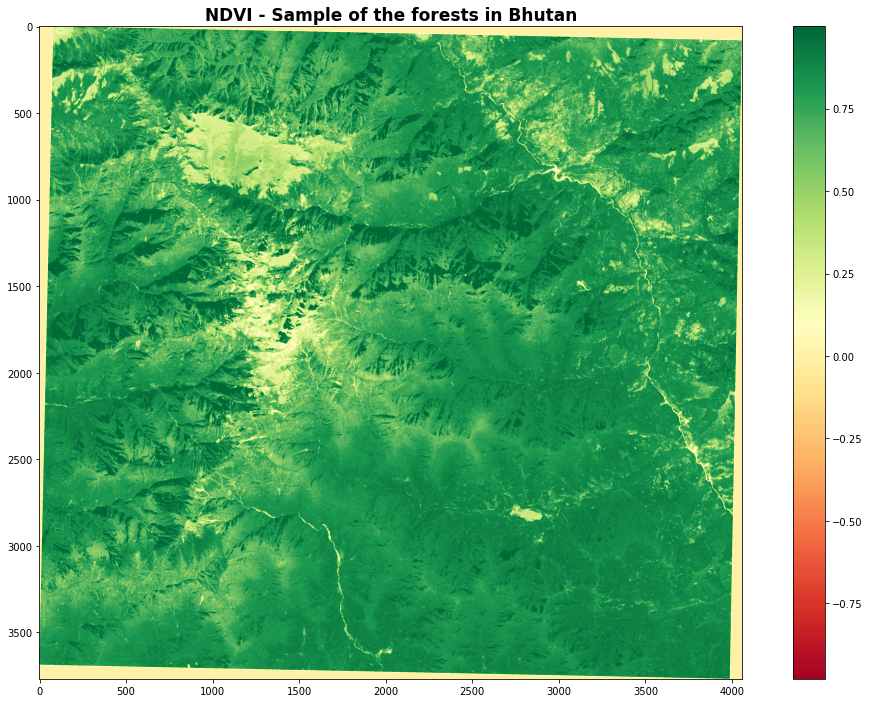

In [27]:
# Plot ndvi
# Set min/max values from NDVI range for image

min=np.nanmin(ndvi)
max=np.nanmax(ndvi)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlGn 
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)

# Specify the input data, colormap and norm for the colorbar
cbar_plot = ax.imshow(ndvi, cmap=colormap, norm=norm)

# Set a title 
ax.set_title('NDVI - Sample of the forests in Bhutan', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot)

# Call 'savefig' to save this plot to an image file
fig.savefig("ndvi-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# Let's visualize
plt.show()

### Here we are going to create an HTML map with the Folium package

In [28]:
# Use rasterio to open the image
with rio.open('./results/sentinel_2/ndvi_Image.tiff') as src:
    boundary = src.bounds
    Bhutan_ndvi = src.read()
    nodata = src.nodata

#Bhutan_ndvi

In [29]:
# Selection of RdYlGn colors for NDVI image in folium
cm = matplotlib.cm.get_cmap('RdYlGn')
colored_data = cm(Bhutan_ndvi)

#colored_data[0]

In [30]:
# Create a map using Stamen Terrain, centered on study area with set zoom level
Bhutan = folium.Map(location=[27.25, 90.4],
                    tiles='Stamen Terrain', zoom_start = 8)

# Add effected buildings
folium.GeoJson(Bhutan_forest, name = 'bhutan_forest.geojson').add_to(Bhutan)

# Overlay raster called img using add_child() function (opacity and bounding box set)
folium.raster_layers.ImageOverlay(image=colored_data[0],
                                  name='Sample Map NDVI - Bhutan forests',
                                  opacity=.7,
                                  bounds =[[27.105424599204458, 90.23863465716029], 
                                           [27.43797110373558, 90.64090865457698]]).add_to(Bhutan);

folium.LayerControl().add_to(Bhutan)

# Display map & save map as Cloud Optimized GeoTIFF
Bhutan

# Save the HTML map
Bhutan.save("Bhutan_NDVI.html")

### Generating a histogram of NDVI values
#### A Histogram could be useful for quick analysis by giving a visual insight into the distribution of "healthy" vs "unhealthy" vegetation values in your study area.

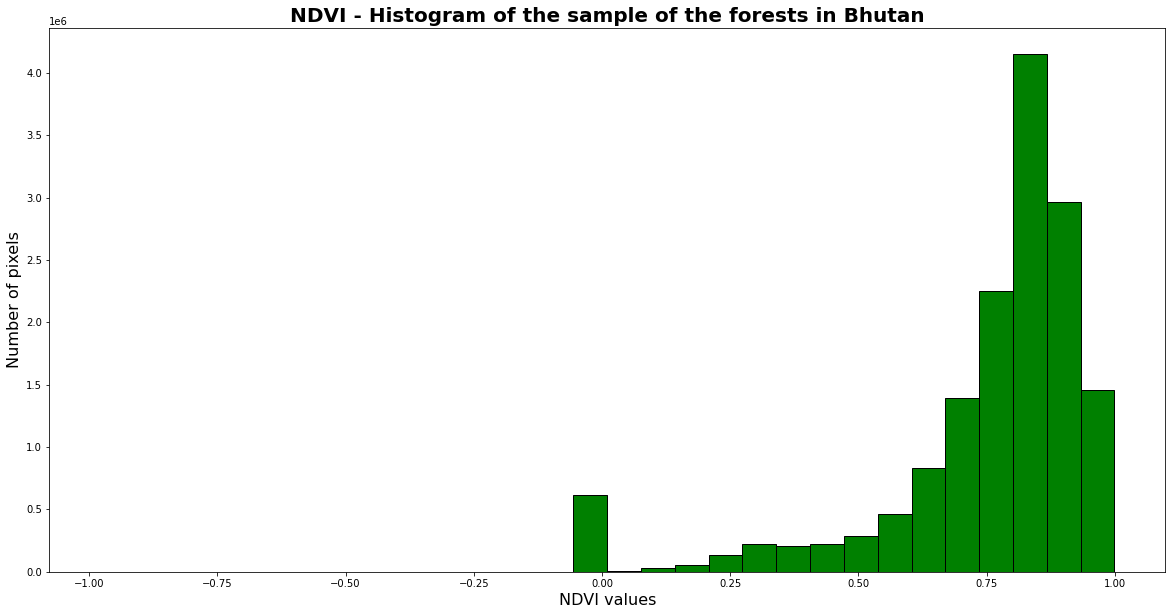

In [31]:
# Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("NDVI - Histogram of the sample of the forests in Bhutan", fontsize=20, fontweight='bold')
plt.xlabel("NDVI values", fontsize=16)
plt.ylabel("Number of pixels", fontsize=16)

# For the x-axis, we want to count every pixel that is not an empty value
x = Bhutan_ndvi[~np.isnan(Bhutan_ndvi)]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
fig2.savefig("Bhutan_ndvi_histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)

# Let's visualize
plt.show()

#### Healthy, dense vegetation canopy should be above 0.5, and sparse vegetation will most likely fall within 0.2 to 0.5. However, it’s only a rule of thumb and you should always take into account the season, type of plant and regional peculiarities to know exactly what NDVI values mean.
#### In most cases, NDVI values between 0.2 and 0.4 correspond to areas with sparse vegetation; moderate vegetation tends to vary between 0.4 and 0.6; anything above 0.6 indicates the highest possible density of green leaves.
#### Traditionally, NDVI results are presented as a color map, where each color corresponds to a certain range of values. There’s no standard color palette, but most software uses the “red-green” one, meaning that red-orange-yellow tints indicate bare soil or dead/sparse vegetation, and all shades of green are a sign of normal to dense vegetation cover.